<a href="https://colab.research.google.com/github/irilee5/DATASCI-266-final-project/blob/main/Plant_Village_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

Random Seed

In [45]:
tf.random.set_seed(42)
np.random.seed(42)

Dataset

In [46]:
from google.colab import drive
drive.mount('/content/drive')
dataset_path = "/content/drive/MyDrive/PlantVillage"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 10

In [48]:
tomato_classes = [
    'Tomato_Spider_mites_Two_spotted_spider_mite',
    'Tomato_Late_blight',
    'Tomato_Bacterial_spot',
    'Tomato__Tomato_mosaic_virus',
    'Tomato_healthy',
    'Tomato__Target_Spot',
    'Tomato_Leaf_Mold',
    'Tomato__Tomato_YellowLeaf__Curl_Virus',
    'Tomato_Early_blight',
    'Tomato_Septoria_leaf_spot'
]


Found 16020 tomato leaf images across 10 classes


<ipython-input-49-9a0742e5a785>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


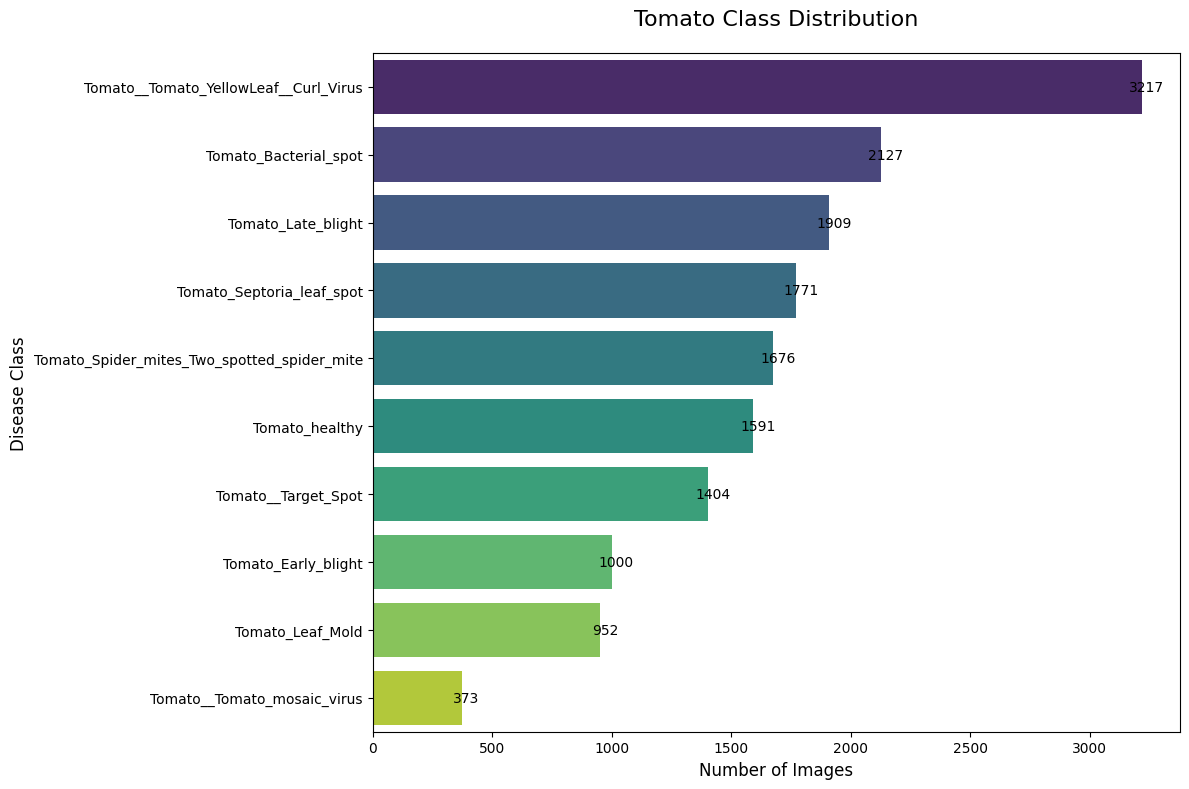

In [49]:
def create_tomato_dataset(dataset_path):
    image_paths = []
    labels = []

    for class_name in tomato_classes:  # Only iterate through tomato classes
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.exists(class_dir):
            for img_file in os.listdir(class_dir):
                if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(class_dir, img_file))
                    labels.append(class_name)
        else:
            print(f"Warning: Directory not found for class {class_name}")

    return pd.DataFrame({'file_path': image_paths, 'label': labels})

# Create DataFrame with ONLY tomato classes
df = create_tomato_dataset(dataset_path)

# Check if DataFrame is empty
if df.empty:
    print("Error: No images found! Check your dataset path and directory structure.")
else:
    print(f"Found {len(df)} tomato leaf images across {len(tomato_classes)} classes")

    # Display class distribution with proper plotting
    plt.figure(figsize=(12, 8))
    ax = sns.countplot(
        data=df,
        y='label',
        order=df['label'].value_counts().index,
        palette="viridis"
    )

    # Add count annotations
    for p in ax.patches:
        width = p.get_width()
        ax.text(
            width + 20,
            p.get_y() + p.get_height()/2.,
            f'{int(width)}',
            ha='center',
            va='center'
        )

    plt.title('Tomato Class Distribution', fontsize=16, pad=20)
    plt.xlabel('Number of Images', fontsize=12)
    plt.ylabel('Disease Class', fontsize=12)
    plt.tight_layout()
    plt.show()

In [50]:
# Split into train, validation, and test sets
train_df, val_df = np.split(df.sample(frac=1, random_state=42),
                           [int(.8*len(df))])
val_df, test_df = np.split(val_df, [int(.5*len(val_df))])

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Training samples: 12816
Validation samples: 1602
Test samples: 1602


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [51]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

In [52]:
# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='file_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 12816 validated image filenames belonging to 10 classes.
Found 1602 validated image filenames belonging to 10 classes.
Found 1602 validated image filenames belonging to 10 classes.


In [53]:
# Build the model using EfficientNetB0 as base
def build_model(num_classes):
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
        pooling='avg'
    )

    # Freeze the base model
    base_model.trainable = False

    model = Sequential([
        base_model,
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

model = build_model(NUM_CLASSES)

In [54]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)


In [55]:
from sklearn.utils import class_weight
import numpy as np

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))


In [56]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size,
    callbacks=[early_stopping, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1358s 3s/step - accuracy: 0.1193 - loss: 2.9415 - val_accuracy: 0.2150 - val_loss: 2.2144 - learning_rate: 0.0010
Epoch 2/10
  1/400 ━━━━━━━━━━━━━━━━━━━━ 14:19 2s/step - accuracy: 0.1250 - loss: 2.3275

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


400/400 ━━━━━━━━━━━━━━━━━━━━ 130s 321ms/step - accuracy: 0.1250 - loss: 2.3275 - val_accuracy: 0.2150 - val_loss: 2.2148 - learning_rate: 0.0010
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1343s 3s/step - accuracy: 0.1609 - loss: 2.3039 - val_accuracy: 0.2150 - val_loss: 2.1834 - learning_rate: 0.0010
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 144s 357ms/step - accuracy: 0.1562 - loss: 2.4071 - val_accuracy: 0.2150 - val_loss: 2.1836 - learning_rate: 0.0010
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1369s 3s/step - accuracy: 0.1811 - loss: 2.2461 - val_accuracy: 0.2150 - val_loss: 2.1870 - learning_rate: 0.0010
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 132s 326ms/step - accuracy: 0.2188 - loss: 2.1311 - val_accuracy: 0.2150 - val_loss: 2.1869 - learning_rate: 0.0010
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1400s 3s/step - accuracy: 0.1878 - loss: 2.2254 - val_accuracy: 0.2150 - val_loss: 2.1832 - learning_rate: 2.0000e-04
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 133s 327ms/step - accuracy: 0.0938 - 

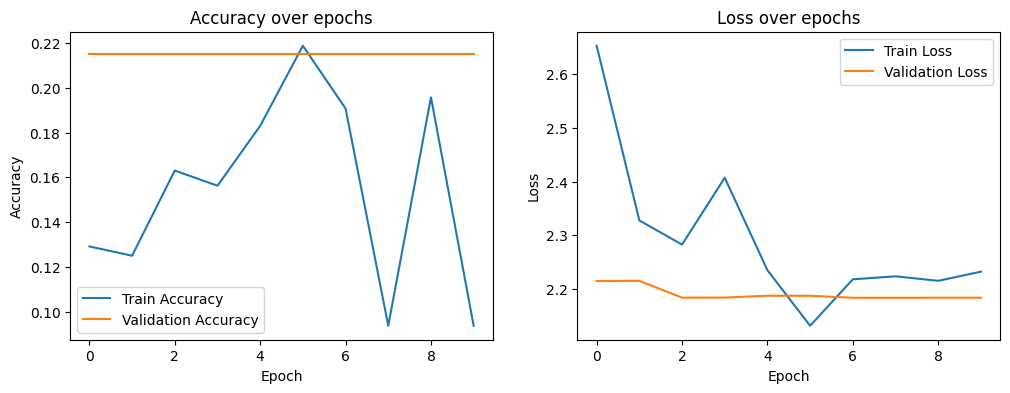

In [57]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()

plot_history(history)